In [77]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from model import MFNN1, MFNN2, MLP
import utils 
from torch.optim.swa_utils import AveragedModel
import numpy as np
#import pandas as pd
import sys
import time
import random
from dataclasses import dataclass
from sam import SAM
from nsam import NSAM
from pyhessian import hessian
import matplotlib.pyplot as plt

In [78]:
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.empty_cache()
    torch.cuda.set_device(7)

In [79]:
config = utils.configs(opt_type='SWA',
                       dataset='FashionMNIST', 
                       model='MFNN1', 
                       scheduler=1, 
                       lr=0.1, bs=60, 
                       rho = 10, 
                       epochs = 100)

root = utils.make_root(config)
path = utils.get_path(root)

config

configs(model='MFNN1', opt_type='SWA', scheduler=1, dataset='FashionMNIST', lr=0.1, bs=60, weight_decay=0.0, momentum=0.0, rho=10, epochs=100)

In [80]:
loader_train, loader_test = utils.make_data_loader(config)

In [81]:
def cal_hess():
    hess_trace = 0.0
    for X, t in loader_train:
        #hess = hessian(model, loss_fn, data=(X, t), cuda=False)
        hess_trace = hess_trace + np.mean(hessian(model, loss_fn, data=(X, t), cuda=True).trace()) 
    return hess_trace

In [82]:
def main(model, opt, loss_fn, scheduler, config):
    rho = config.rho
    swa_start = 50
    hess_list = []
    for epoch in range(config.epochs):
        with open(path, 'a') as f:
            f.write(f'EPOCH: {epoch}\n')
        print(f'EPOCH: {epoch}')
        
        start = time.time() 
        
        #start train loop----------------------
        train_loss = []
        total_train = 0
        correct_train = 0
        
        model.train()
        for X, t in loader_train:
            X, t = X.cuda(), t.cuda()
            y = model(X)
            opt.zero_grad() 
            opt_type = config.opt_type
                          
            if opt_type == 'NSAM' or opt_type == 'SAM':
                with torch.no_grad():
                    loss = loss_fn(y, t)
                    opt.first_step(zero_grad=True)
                loss_fn(model(X), t).backward()
                opt.second_step(zero_grad=True)
            elif opt_type == 'SGD':
                loss = loss_fn(y, t)
                loss.backward()
                opt.step()
            elif opt_type == 'SWA':
                loss = loss_fn(y, t)
                loss.backward()
                opt.step()
                if epoch > swa_start:
                    averaged.update_parameters(model)
        
            pred = y.argmax(1)
            train_loss.append(loss.tolist())
            
            total_train += t.shape[0]
            correct_train += (pred==t).sum().item()
          
        scheduler.step()
    
        end  = time.time()
        
        log = f'train loss: {np.mean(train_loss):.3f}, accuracy: {correct_train/total_train:.3f}'
        with open(path, 'a') as f:
            f.write(log + f' train_time: {end - start:.5f}' + '\n')
        print(log)
        #end train loop------------------------------------
                
        #start test loop-----------------------------------
        test_loss = []
        total_test= 0
        correct_test = 0
    
        model.eval()
        
        hess_tr = cal_hess()
        hess_list.append(hess_tr)
        
        for X, t in loader_test:
            X, t = X.cuda(), t.cuda()
            if opt_type == 'SWA':
                y = averaged(X)
            else:
                y = model(X)
            loss = loss_fn(y, t)
            
            pred = y.argmax(1)
            test_loss.append(loss.tolist())
            
            total_test += t.shape[0]
            correct_test += (pred==t).sum().item()
    
        log = f'test loss: {np.mean(test_loss):.3f}, accuracy: {correct_test/total_test:.3f}' + f"hessian trace = {hess_tr}"
        with open(path, 'a') as f:
            f.write(log + '\n')
        print(log)
        print(f"hessian trace = {hess_tr}")
        # end test loop-------------------------------------- 
        
        print(f'time: {end - start:.5f}')    
        
    return hess_list

In [ ]:
model = MFNN1().cuda()
averaged = AveragedModel(model)

base_optimizer = optim.SGD

if config.opt_type == 'SGD' or 'SWA':
    opt = optim.SGD(model.parameters(), lr = config.lr)
elif config.opt_type == 'SAM':
    opt = SAM(model.parameters(), base_optimizer, lr = config.lr, rho = config.rho, device=device)
elif config.opt_type == 'NSAM':
    opt = NSAM(model.parameters(), base_optimizer, lr = config.lr, rho = config.rho, device=device)

loss_fn = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.LambdaLR(opt, lr_lambda = utils.func, verbose=True)
hess_list = main(model, opt, loss_fn, scheduler, config)

Adjusting learning rate of group 0 to 1.0000e-01.
EPOCH: 0
Adjusting learning rate of group 0 to 1.0000e-01.
train loss: 0.778, accuracy: 0.727
test loss: 2.303, accuracy: 0.096hessian trace = 83829.55866890446
hessian trace = 83829.55866890446
time: 2.01699
EPOCH: 1
Adjusting learning rate of group 0 to 1.0000e-01.
train loss: 0.474, accuracy: 0.831
test loss: 2.303, accuracy: 0.096hessian trace = 69368.33824906459
hessian trace = 69368.33824906459
time: 2.08517
EPOCH: 2
Adjusting learning rate of group 0 to 1.0000e-01.
train loss: 0.413, accuracy: 0.852
test loss: 2.303, accuracy: 0.096hessian trace = 65313.37330257399
hessian trace = 65313.37330257399
time: 2.06920
EPOCH: 3
Adjusting learning rate of group 0 to 1.0000e-01.
train loss: 0.377, accuracy: 0.865
test loss: 2.303, accuracy: 0.096hessian trace = 68804.86043786445
hessian trace = 68804.86043786445
time: 2.00927
EPOCH: 4
Adjusting learning rate of group 0 to 1.0000e-01.
train loss: 0.352, accuracy: 0.873
test loss: 2.303, ac

<function matplotlib.pyplot.show(close=None, block=None)>

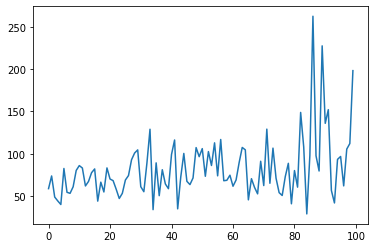

In [41]:
x = np.arange(0,100,1)
y = hess_list
plt.plot(x,y)
plt.show

torch.Size([60000, 28, 28])


In [12]:
model = MFNN1()
loss_fn = nn.CrossEntropyLoss()
hess_train = 0

for X, t in hess_loader:
    #print(len(hess_loader))
    hess = hessian(model, loss_fn, data=(X, t), cuda=False)
    print('#######################################################')
    hess_train = hess_train + np.mean(hessian(model, loss_fn, data=(X, t), cuda=False).trace())
    print(hess_train)

/Users/maedashugo/opt/anaconda3/envs/jax/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1646756029501/work/torch/csrc/autograd/engine.cpp:985.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


#######################################################
-8.463426113128662
#######################################################
-48.278451442718506
#######################################################
-42.88778066635132
#######################################################
-24.77126455307007
#######################################################
-16.804104197621346
#######################################################
-45.72639404594898
#######################################################
-15.555562365651127
#######################################################
-78.39512859642505
#######################################################
-73.99734138721021
#######################################################
-51.05204796069654
